In [1]:
%load_ext autoreload
%autoreload 2

In [26]:
import os
from pathlib import Path
from omegaconf import OmegaConf
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

In [36]:
res = pickle_open('/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/outputs/2024-12-20-rankR/fixed_eigval_true-eigh_est-rotatem/k3-chlg4-rotate-gaussian-rank1-nz9/seed-7/False/11-49-28/res.pickle')

In [39]:
res['gamma_lowrank'].eigvecs

Array([[[nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj],
        [nan+nanj, nan+nanj]]], dtype=complex64)

In [8]:
eigvecs_em = jnp.stack([res['track']['gamma_lowrank'][r].eigvecs.squeeze() for r in range(len(res['track']['gamma_lowrank']))])

In [9]:
eigvecs_em.shape

(26, 3)

In [35]:
eigvals = res['gamma_init'].eigvals

In [36]:
eigvecs_em.shape
j = 0
covs = jnp.stack([eigvals.squeeze() * jnp.outer(eigvecs_em[r,:], eigvecs_em[r,:].conj()) for r in range(eigvecs_em.shape[0])])

In [43]:
jnp.trace(covs[3])

Array(3000.+6.9306107e-06j, dtype=complex64)

In [45]:
evec_true = res['eigvecs_true'].squeeze()

In [48]:
jnp.round(eigvals.squeeze()*jnp.outer(evec_true, evec_true.conj()), 0)

Array([[1000.  +0.j,  302.-953.j,  134.-991.j],
       [ 302.+953.j, 1000.  +0.j,  985.-172.j],
       [ 134.+991.j,  985.+172.j, 1000.  -0.j]], dtype=complex64)

In [38]:
jnp.round(covs, 0)

Array([[[ 515.   -0.j,  799. +196.j,  188. -753.j],
        [ 799. -196.j, 1315.   -0.j,    5.-1241.j],
        [ 188. +753.j,    5.+1241.j, 1170.   -0.j]],

       [[1711.   +0.j, -636. -999.j,  786. +431.j],
        [-636. +999.j,  819.   +0.j, -544. +299.j],
        [ 786. -431.j, -544. -299.j,  470.   +0.j]],

       [[ 515.   +0.j,  799. +196.j,  188. -753.j],
        [ 799. -196.j, 1315.   -0.j,    5.-1241.j],
        [ 188. +753.j,    5.+1241.j, 1170.   -0.j]],

       [[1711.   -0.j, -636. -999.j,  786. +431.j],
        [-636. +999.j,  819.   +0.j, -544. +299.j],
        [ 786. -431.j, -544. -299.j,  470.   +0.j]],

       [[ 515.   -0.j,  799. +196.j,  188. -753.j],
        [ 799. -196.j, 1315.   -0.j,    5.-1241.j],
        [ 188. +753.j,    5.+1241.j, 1170.   -0.j]],

       [[1711.   +0.j, -636. -999.j,  786. +431.j],
        [-636. +999.j,  819.   +0.j, -544. +299.j],
        [ 786. -431.j, -544. -299.j,  470.   +0.j]],

       [[ 515.   +0.j,  799. +196.j,  188. -753.j],


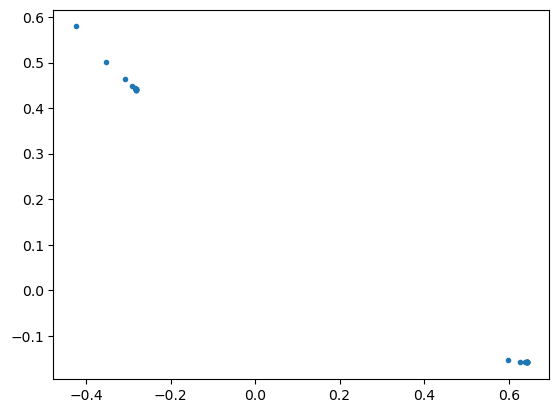

In [23]:
k = 0
rr = eigvecs_em[:,1].real 
ii = eigvecs_em[:,1].imag 

plt.plot(rr,ii, '.')

In [10]:
jnp.angle(res['gamma_init'].eigvecs)

Array([[[ 8.7422769e-08],
        [-2.4105398e-01],
        [ 1.3259273e+00]]], dtype=float32)

In [11]:
jnp.angle(res['gamma_init'].eigvecs)

Array([[[ 3.1415927],
        [-1.8500749],
        [-1.496515 ]]], dtype=float32)

In [10]:
cfg = res['cfg']
lcfg = cfg.latent
ocfg = cfg.obs

lcfg.L
ocfg.ov1

1.0

In [3]:
from cohlib.jax.simtools import load_gamma
from cohlib.jax.wrangle  import filter_loaded, filter_load_results
from cohlib.jax.dists import sample_from_gamma, sample_obs, sample_ccn_rank1, naive_estimator
from cohlib.jax.observations import add0
def get_naive_and_oracle(res_load, Ls, ov_pairs, K, Nnz, gamma_name):
    naive_ests = jnp.zeros((Ls.size, ov_pairs.shape[0], Nnz, K, K), dtype=complex)
    oracle_ests = jnp.zeros((Ls.size, ov_pairs.shape[0], Nnz, K, K), dtype=complex)
    for l, L in enumerate(Ls):
        for a, ov_pair in enumerate(ov_pairs):
            ov1 = ov_pair[0]
            ov2 = ov_pair[1]
            print(f'L: {L},  obs_var: {ov1}e{ov2}' )
            lsel = {'L': L,
            'gamma': gamma_name}
            msel = {}
            osel = {'ov1': ov1, 'ov2': ov2}
            res = filter_loaded(res_load, lsel, msel, osel)

            
            if type(res) is list:
                print('Warning: Using first of multiple results!')
                res = res[0]
            cfg = res['cfg']
            lcfg = cfg.latent
            ocfg = cfg.obs

            gamma_load = load_gamma(cfg)
            nz_target = gamma_load['target_inds']
            freqs = gamma_load['freqs']
            eigvecs = gamma_load['eigvecs']
            eigvals = gamma_load['eigvals']

            nz_model = nz_target

            lrk = jr.key(lcfg.seed)

            gamma_full_dummytarget = jnp.zeros((freqs.size, K, K), dtype=complex)
            gamma_full_dummytarget = gamma_full_dummytarget.at[nz_target,:,:].set(jnp.eye(K, dtype=complex))

            zs = sample_from_gamma(lrk, gamma_full_dummytarget, lcfg.L)

            for j, ind in enumerate(nz_target):
                zs_target = sample_ccn_rank1(lrk, eigvecs[j,:].squeeze(), eigvals[j].squeeze(), K, lcfg.L)
                zs = zs.at[nz_target,:,:].set(zs_target)

            zs_0dc = jnp.apply_along_axis(add0, 0, zs)
            xs = jnp.fft.irfft(zs_0dc, axis=0)


            obs, obs_params = sample_obs(ocfg, xs)
            naive_est = naive_estimator(obs, nz_model)
            naive_ests = naive_ests.at[l,a,:,:,:].set(naive_est)

            gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz_model,:,:], zs[nz_model,:,:].conj()).mean(-1)
            oracle_ests = oracle_ests.at[l,a,:,:,:].set(gamma_oracle)
        
    return naive_ests, oracle_ests

In [12]:
K = 3
Nnz = 1
Ls = jnp.array([10, 25])
ov_pairs = jnp.array([(1, 0), (5.0, 0)])
gamma_name = f'k{K}-chlg4-rotate-gaussian-rank1-nz9'
seed = 7
init_use = 'empirical_init'
num_iters = 25

# res_paths = [f'/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/outputs/2024-12-18-fixed_eigval_true-eigh_est/{gamma_name}/seed-{seed}']
m_step_init = 'warm_init'
# res_paths = [f'/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/outputs/2024-12-20-fixed_eigval_true-gd-rotatem/{gamma_name}/seed-{seed}/{m_step_init}']
res_paths = [f'/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/outputs/2024-12-20-fixed_eigval_true-gd-rotatem/k3-chlg4-rotate-gaussian-rank1-nz9/seed-7/warm_start']


# nests, oests = get_naive_and_oracle(res_load, Ls, ov_pairs, K, Nnz, gamma_name)

In [13]:
sel_paths = []
for path in res_paths:
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        print(exp)

/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/outputs/2024-12-20-fixed_eigval_true-gd-rotatem/k3-chlg4-rotate-gaussian-rank1-nz9/seed-7/warm_start/08-33-45
/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/outputs/2024-12-20-fixed_eigval_true-gd-rotatem/k3-chlg4-rotate-gaussian-rank1-nz9/seed-7/warm_start/08-31-43
/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/outputs/2024-12-20-fixed_eigval_true-gd-rotatem/k3-chlg4-rotate-gaussian-rank1-nz9/seed-7/warm_start/08-35-05
/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/outputs/2024-12-20-fixed_eigval_true-gd-rotatem/k3-chlg4-rotate-gaussian-rank1-nz9/seed-7/warm_start/08-36-26
/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/outputs/2024-12-20-fixed_eigval_true-gd-rotatem/k3-chlg4-rotate-gaussian-rank1-nz9/seed-7/warm_start/08-35-46
/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/outputs/2024-12-20-fixed_eigval_true-gd-rotatem/k3-chlg4-rotate-ga

In [14]:
lcfg_attrs = {'seed': seed}
# init_use = 'empirical-init'
init_use = 'oracle-init'

if init_use == 'flat-init':

    init = 'flat-init'
    scale_init = 100
    mcfg_attrs = {'emiters': num_iters,
                'init': init,
                'scale_init': scale_init}


if init_use == 'empirical-init':
    init = 'empirical-init'
    mcfg_attrs = {'emiters': num_iters,
                'init': init}


ocfg_attrs = {'obs_type': 'gaussian', 'seed': seed}

res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)

4 paths found meeting critera


In [20]:
from cohlib.jax.simtools import load_gamma
gamma_load = load_gamma(res_load[0]['cfg'])

In [25]:
gamma_load['target_inds']

Array([9], dtype=int32)

In [10]:
naive_ests, oracle_ests = get_naive_and_oracle(res_load, Ls, ov_pairs, K, Nnz, gamma_name)

L: 10,  obs_var: 1.0e0.0
Returned single result.
Sampling Gaussian observations with variance 1.0e^0
L: 10,  obs_var: 5.0e0.0
Returned single result.
Sampling Gaussian observations with variance 5.0e^0
L: 25,  obs_var: 1.0e0.0
Returned single result.
Sampling Gaussian observations with variance 1.0e^0
L: 25,  obs_var: 5.0e0.0
Returned single result.
Sampling Gaussian observations with variance 5.0e^0


In [13]:
L = Ls[-1]
ov_pair = ov_pairs[0]
ov1 = ov_pair[0]
ov2 = ov_pair[1]
print(f'L: {L},  obs_var: {ov1}e{ov2}' )
lsel = {'L': L,
'gamma': gamma_name}
msel = {}
osel = {'ov1': ov1, 'ov2': ov2}
res = filter_loaded(res_load, lsel, msel, osel)

L: 25,  obs_var: 1.0e0.0
Returned single result.


In [38]:
jrkey = jr.PRNGKey(5)
A = jr.normal(jrkey, (3,3)) + jr.normal(jrkey+1, (3,3))*1j
G = A.T.conj() @ A
_, eigvecstest = jnp.linalg.eigh(G)

In [61]:
from cohlib.jax.lr_model import rotate_eigvecs

In [71]:
test = rotate_eigvecs(eigvecstest[None,:,:])

eigvecstest = rotate_eigvecs(eigvecstest[None,:,:])

In [73]:
jnp.round(eigvecstest,1)

Array([[[ 0.3+0.j ,  0.6+0.j ,  0.7+0.j ],
        [-0.6-0.j ,  0.6+0.2j, -0.3-0.2j],
        [-0.4-0.6j,  0. -0.4j,  0.1+0.6j]]], dtype=complex64)

In [70]:
print(jnp.round(eigvecstest,1))
print()
print(jnp.round(test,1))

[[ 0.3+0.j   0.6+0.j  -0.7-0.j ]
 [-0.6-0.j   0.6+0.2j  0.3+0.2j]
 [-0.4-0.6j  0. -0.4j -0.1-0.6j]]

[[[ 0.3+0.j   0.6+0.j   0.7+0.j ]
  [-0.6-0.j   0.6+0.2j -0.3-0.2j]
  [-0.4-0.6j  0. -0.4j  0.1+0.6j]]]


In [59]:
thetas = jnp.angle(eigvecstest[0,:])
rotations = jnp.exp(-1j*thetas)

temp = eigvecstest * rotations[None,:]
print(jnp.round(eigvecstest, 4))
print('')
print(jnp.round(temp,4))

[[ 0.2895    +0.j          0.6238    +0.j         -0.726     -0.j        ]
 [-0.6368    -0.018j       0.64019996+0.2393j      0.2962    +0.19839999j]
 [-0.35959998-0.6173j      0.0073    -0.3791j     -0.1371    -0.5719j    ]]

[[ 0.2895    +0.j          0.6238    +0.j          0.726     +0.j        ]
 [-0.6368    -0.018j       0.64019996+0.2393j     -0.2962    -0.19839999j]
 [-0.35959998-0.6173j      0.0073    -0.3791j      0.1371    +0.5719j    ]]


In [16]:
eigvecs_init = res['gamma_init'].eigvecs
rank = 1
j = 0

for r in range(rank):
    # if eigvecs_init[j,0,r].real < 0:
    print(eigvecs_init[j,:,r])
    print(jnp.angle(eigvecs_init[j,:,r]))
    print('')
    print(-eigvecs_init[j,:,r])
    print(jnp.angle(-eigvecs_init[j,:,r]))
    # eigvecs_init[j,:,r] = -eigvecs_init[j,:,r]

[ 0.6880468 -0.j          0.14250904+0.49693948j -0.03779285+0.50784427j]
[-0.         1.2915177  1.6450776]

[-0.6880468 +0.j         -0.14250904-0.49693948j  0.03779285-0.50784427j]
[ 3.1415927 -1.8500749 -1.496515 ]


In [32]:
evec = eigvecs_init[j,:,r]
theta = jnp.angle(eigvecs_init[j,:,r])
print(evec)
print(theta)
print(evec*jnp.exp(-1j*theta[0]))

[ 0.6880468 -0.j          0.14250904+0.49693948j -0.03779285+0.50784427j]
[-0.         1.2915177  1.6450776]
[ 0.6880468 +0.j          0.14250904+0.49693948j -0.03779285+0.50784427j]


In [77]:
for l, L in enumerate(Ls):
    for a, ov_pair in enumerate(ov_pairs):
        ov1 = ov_pair[0]
        ov2 = ov_pair[1]
        print(f'L: {L},  obs_var: {ov1}e{ov2}' )
        lsel = {'L': L,
        'gamma': gamma_name}
        msel = {}
        osel = {'ov1': ov1, 'ov2': ov2}
        res = filter_loaded(res_load, lsel, msel, osel)
        print(res['cfg'].model.init)
        print(res['gamma_init'].eigvecs.squeeze())
        naive_gamma = naive_ests[l,a,0,:,:]
        _, naive_eigvecs = jnp.linalg.eigh(naive_gamma)
        print(naive_eigvecs[:,-1])
        print(jnp.angle(-naive_eigvecs[:,-1]))
        print(jnp.angle(res['eigvecs_true'].squeeze()))

L: 10,  obs_var: 1.0e0.0
Returned single result.
empirical-init
[0.41418675+0.j         0.6430016 -0.15807179j 0.15139921+0.60587895j]
[-0.41418675-0.j         -0.6430016 +0.15807179j -0.15139921-0.60587895j]
[ 0.         -0.24105409  1.3259273 ]
[5.4962399e-09 1.2640250e+00 1.4364921e+00]
L: 10,  obs_var: 5.0e0.0
Returned single result.
empirical-init
[0.28195736+0.j         0.14182377-0.73196745j 0.41871023+0.43507645j]
[-0.28195736-0.j         -0.14182377+0.73196745j -0.41871023-0.43507645j]
[ 0.        -1.3794109  0.8045648]
[5.4962399e-09 1.2640250e+00 1.4364921e+00]
L: 25,  obs_var: 1.0e0.0
Returned single result.
empirical-init
[ 0.6880468 -0.j          0.14250904+0.49693948j -0.03779285+0.50784427j]
[-0.6880468 +0.j         -0.14250904-0.49693948j  0.03779285-0.50784427j]
[-0.         1.2915177  1.6450776]
[5.4962399e-09 1.2640250e+00 1.4364921e+00]
L: 25,  obs_var: 5.0e0.0
Returned single result.
empirical-init
[ 0.80900216+0.j         -0.08510447+0.39580968j -0.23840131+0.353

In [28]:
num_iters = 25
lcfg_attrs = {}

init_use = 'flat-init'

if init_use == 'flat-init':

    init = 'flat-init'
    scale_init = 100
    mcfg_attrs = {'emiters': num_iters,
                'init': init,
                'scale_init': scale_init}


if init_use == 'empirical-init':
    init = 'empirical-init'
    mcfg_attrs = {'emiters': num_iters,
                'init': init}


ocfg_attrs = {'obs_type': 'gaussian'}



res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/gaussian_obs_postfix/batch/outputs/2024-12-09-seed7']

res_load = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
# res_load = filter_load_results(res_paths, {}, {}, {})
# alphas = sorted([r['cfg'].obs.alpha for r in res_load])
# Ls = sorted([r['cfg'].latent.L for r in res_load])


24 paths found meeting critera


In [9]:
K = 3
gamma_name = f'k{K}-chlg4-gaussian-rank1-nz9'

L = 10
ov2 = -1
ov1 = 1.0
lsel = {'L': L,
        'gamma': gamma_name}
msel = {}
osel = {'ov1': ov1, 'ov2': ov2}
res = filter_loaded(res_load, lsel, msel, osel)
cfg = res['cfg']
# gamma_true = res['gamma_true_full']
nz_model = res['params']['model_nonzero_inds']
nz_true = res['params']['true_nonzero_inds']
Nnz = nz_model.size# 

Returned single result.


In [10]:
Ls = jnp.array([10, 25, 50])
ov_pairs = jnp.array([(1, -1), (5.0, -1), 
                      (1, 0), (5.0, 0)])
# ov1s = jnp.array()
# ov2s = jnp.array([-3, -2, -1, 0, 1]
Ks = jnp.array([3, 10])
K = 3
gamma_name = f'k{K}-chlg4-gaussian-rank1-nz9'

In [11]:
# ov_pairs = jnp.array([(2.5, -1), (5.0, -1), (7.5, -1),
#                       (1, 0), (2.5, 0), (5.0, 0)])

In [12]:
from cohlib.jax.dists import naive_estimator, sample_ccn_rank1
from cohlib.jax.simtools import load_gamma


naive_ests = jnp.zeros((Ls.size, ov_pairs.shape[0], Nnz, K, K), dtype=complex)
oracle_ests = jnp.zeros((Ls.size, ov_pairs.shape[0], Nnz, K, K), dtype=complex)
for l, L in enumerate(Ls):
    for a, ov_pair in enumerate(ov_pairs):
        ov1 = ov_pair[0]
        ov2 = ov_pair[1]
        print(f'L: {L},  obs_var: {ov1}e{ov2}' )
        lsel = {'L': L,
        'gamma': gamma_name}
        msel = {}
        osel = {'ov1': ov1, 'ov2': ov2}
        res = filter_loaded(res_load, lsel, msel, osel)

        
        cfg = res['cfg']
        lcfg = cfg.latent
        ocfg = cfg.obs

        gamma_load = load_gamma(cfg)
        nz_target = gamma_load['target_inds']
        freqs = gamma_load['freqs']
        eigvecs = gamma_load['eigvecs']
        eigvals = gamma_load['eigvals']

        lrk = jr.key(lcfg.seed)

        gamma_full_dummytarget = jnp.zeros((freqs.size, K, K), dtype=complex)
        gamma_full_dummytarget = gamma_full_dummytarget.at[nz_target,:,:].set(jnp.eye(K, dtype=complex))

        zs = sample_from_gamma(lrk, gamma_full_dummytarget, lcfg.L)

        for j, ind in enumerate(nz_target):
            zs_target = sample_ccn_rank1(lrk, eigvecs[j,:].squeeze(), eigvals[j].squeeze(), K, lcfg.L)
            zs = zs.at[nz_target,:,:].set(zs_target)

        zs_0dc = jnp.apply_along_axis(add0, 0, zs)
        xs = jnp.fft.irfft(zs_0dc, axis=0)
        params = jnp.array([ocfg.ov2 for _ in range(K)])


        obs, obs_params = sample_obs(ocfg, xs)
        naive_est = naive_estimator(obs, nz_model)
        naive_ests = naive_ests.at[l,a,:,:,:].set(naive_est)

        gamma_oracle = jnp.einsum('jkl,jil->jkil', zs[nz_model,:,:], zs[nz_model,:,:].conj()).mean(-1)
        oracle_ests = oracle_ests.at[l,a,:,:,:].set(gamma_oracle)

L: 10,  obs_var: 1.0e-1.0
Returned single result.
Sampling Gaussian observations with variance 1.0e^-1
L: 10,  obs_var: 5.0e-1.0
Returned single result.
Sampling Gaussian observations with variance 5.0e^-1
L: 10,  obs_var: 1.0e0.0
Returned single result.
Sampling Gaussian observations with variance 1.0e^0
L: 10,  obs_var: 5.0e0.0
Returned single result.
Sampling Gaussian observations with variance 5.0e^0
L: 25,  obs_var: 1.0e-1.0
Returned single result.
Sampling Gaussian observations with variance 1.0e^-1
L: 25,  obs_var: 5.0e-1.0
Returned single result.
Sampling Gaussian observations with variance 5.0e^-1
L: 25,  obs_var: 1.0e0.0
Returned single result.
Sampling Gaussian observations with variance 1.0e^0
L: 25,  obs_var: 5.0e0.0
Returned single result.
Sampling Gaussian observations with variance 5.0e^0
L: 50,  obs_var: 1.0e-1.0
Returned single result.
Sampling Gaussian observations with variance 1.0e^-1
L: 50,  obs_var: 5.0e-1.0
Returned single result.
Sampling Gaussian observations 

In [20]:
_, eigvecs = jnp.linalg.eigh(gamma_oracle)

In [25]:
print(f'eigvecs shape: {eigvecs.shape}')
print('eigvecs:') 
print(jnp.round(eigvecs, 2))
print('leading eigvec:') 
print(eigvecs[:,-1])

eigvecs shape: (1, 3, 3)
eigvecs:
[[[ 0.77      -0.j   -0.29      +0.j    0.58      +0.j  ]
  [-0.22      -0.59j -0.22999999-0.47j  0.17      +0.55j]
  [ 0.01      -0.14j  0.17999999+0.78j  0.08      +0.57j]]]
leading eigvec:
[[0.00987861-0.13974084j 0.18297876+0.78330094j 0.07730772+0.5721511j ]]


In [26]:
eigvecs = eigvecs.squeeze()
print(f'eigvecs shape: {eigvecs.shape}')
print('eigvecs:') 
print(jnp.round(eigvecs, 2))
print('leading eigvec:') 
print(eigvecs[:,-1])

eigvecs shape: (3, 3)
eigvecs:
[[ 0.77      -0.j   -0.29      +0.j    0.58      +0.j  ]
 [-0.22      -0.59j -0.22999999-0.47j  0.17      +0.55j]
 [ 0.01      -0.14j  0.17999999+0.78j  0.08      +0.57j]]
leading eigvec:
[0.5773503 +0.j        0.1743496 +0.5503958j 0.07730772+0.5721511j]


In [20]:
nz_target

Array([9], dtype=int32)

In [24]:
naive_color = 'tab:red'
naive_style = 'dashed'
naive_width = 2

true_color = 'k'
true_style = 'solid'
true_width = 2

oracle_color = 'tab:green'
oracle_style = 'dotted'
oracle_width = 2.5

est_color = 'tab:blue'
est_style = 'solid'
est_width = 2

In [29]:
res.keys()

dict_keys(['cfg', 'gamma_lowrank', 'params', 'gamma_init', 'eigvals_true', 'eigvecs_true', 'track'])

In [33]:
ov_pairs.shape

(4, 2)

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


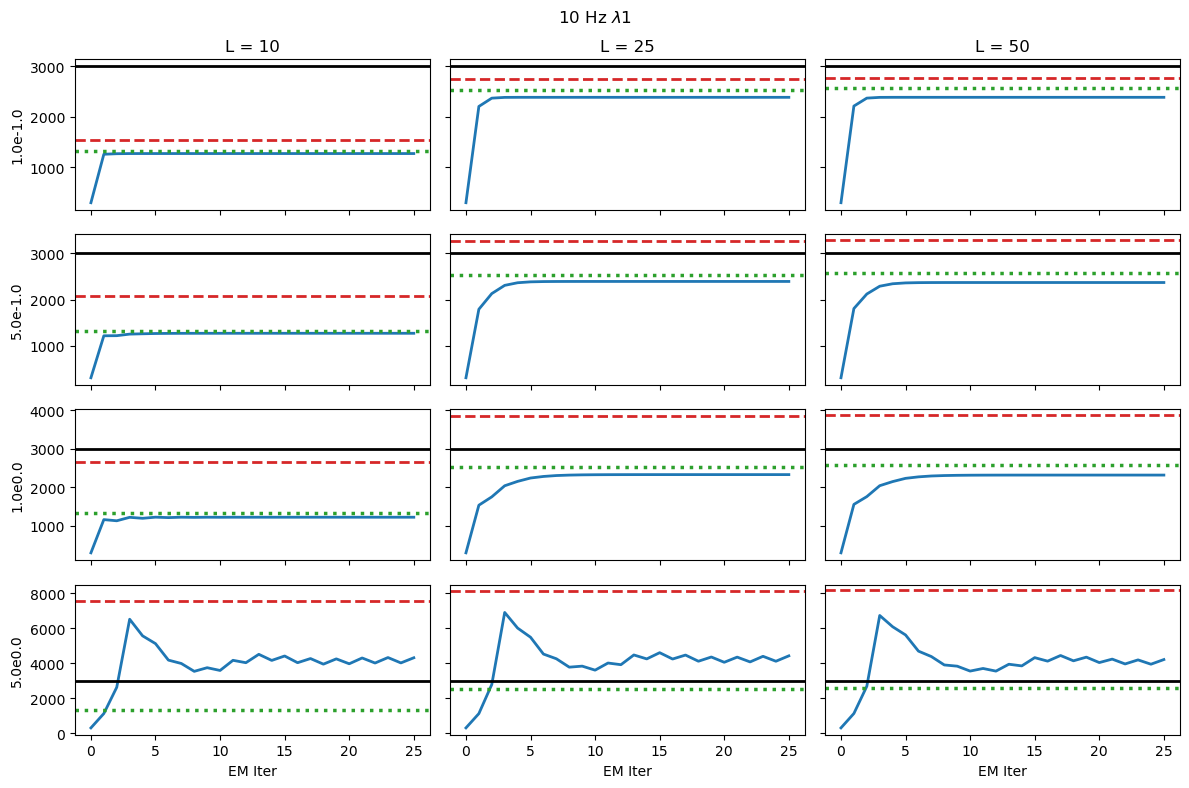

In [36]:
jind = 9
eigrank = 1


fig, ax = plt.subplots(ov_pairs.shape[0], Ls.size, figsize=(12,8), sharex=True, sharey='row')
for l, L in enumerate(Ls):
    for a, ov_pair in enumerate(ov_pairs):
        ov1 = ov_pair[0]
        ov2 = ov_pair[1]
        res = filter_loaded(res_load, lsel, msel, osel)
        lsel = {'L': L, 'gamma': gamma_name}
        msel = {}
        osel = {'ov1': ov1, 'ov2': ov2}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']

        eig_true = res['eigvals_true'].squeeze()
        eigs_em = jnp.stack([x.eigvals.squeeze() for x in res['track']['gamma_lowrank']])

        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_oracle = oracle_ests[l,a,:,:,:]

        oracle_eigval = get_eigval(gamma_oracle[jind,:,:], eigrank)
        naive_eigval = get_eigval(gamma_naive[jind,:,:], eigrank)

        ax[a,l].plot(eigs_em, color=est_color, linestyle=est_style, linewidth=est_width)
        ax[a,l].axhline(eig_true, linestyle=true_style, color=true_color, linewidth=true_width)
        ax[a,l].axhline(oracle_eigval, linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
        ax[a,l].axhline(naive_eigval, linestyle=naive_style, color=naive_color, linewidth=naive_width)

        # ax[a,l].axhline(true_eigval, color='k', label='True')
        # ax[a,l].axhline(naive_eigval, linestyle='--', color=naive_color, label='Naive')
        # ax[a,l].axhline(oracle_eigval, linestyle='--', color='tab:green', label='Oracle',linewidth=3)

        if l == 0:
            ax[a,l].set_ylabel(f'{ov1}e{ov2}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == ov_pairs.shape[0]-1:
            ax[a,l].set_xlabel('EM Iter')

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'$\lambda {eigrank}$')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.


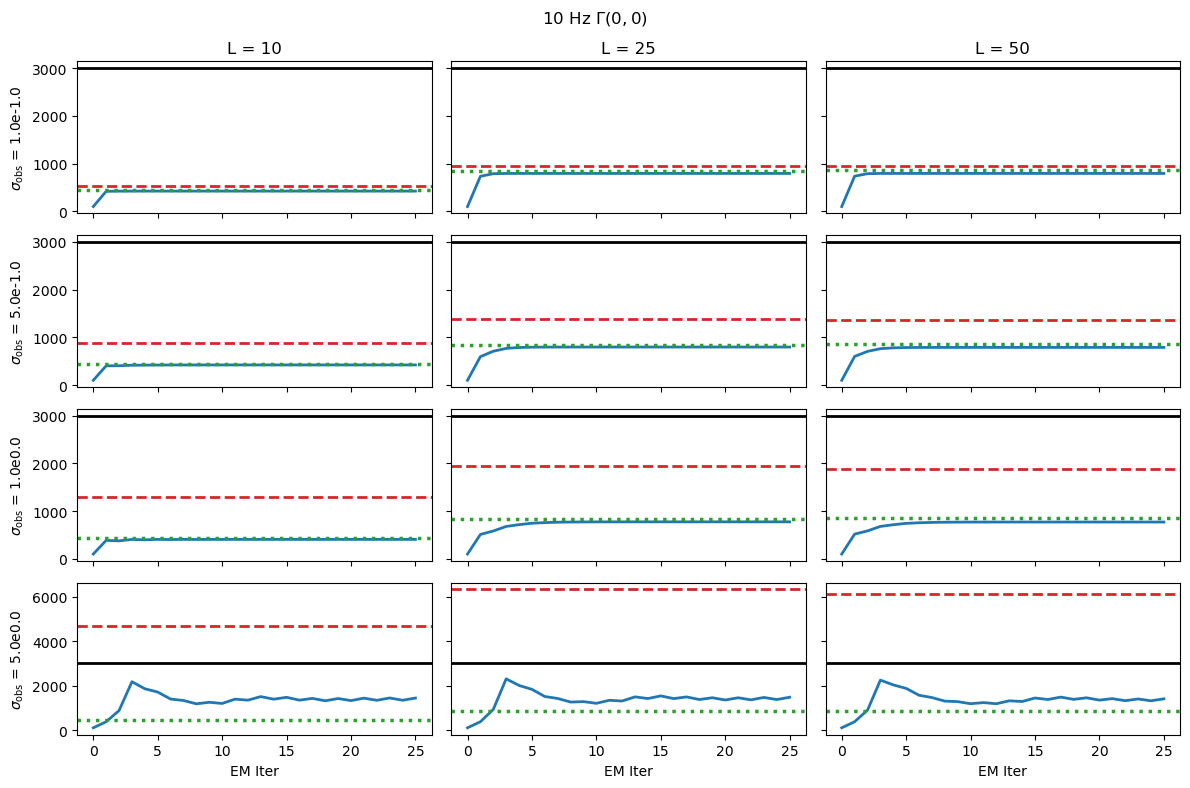

In [35]:
jind = 0
jind_full = 9

K_plot = [0]
# def func(x):
#     return 10*jnp.log10(jnp.real(x))
func = jnp.real

fig, ax = plt.subplots(ov_pairs.shape[0], Ls.size, figsize=(12,8), sharex=True, sharey='row')
for l, L in enumerate(Ls):
    for a, ov_pair in enumerate(ov_pairs):
        ov1 = ov_pair[0]
        ov2 = ov_pair[1]
        res = filter_loaded(res_load, lsel, msel, osel)
        lsel = {'L': L, 'gamma': gamma_name}
        msel = {}
        osel = {'ov1': ov1, 'ov2': ov2}
        
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        eig_true = res['eigvals_true'].squeeze()
        eigs_em = jnp.stack([x.eigvals.squeeze() for x in res['track']['gamma_lowrank']])

        for k in K_plot:
            ax[a,l].plot(eigs_em/K, color=est_color, linestyle=est_style, linewidth=est_width)
            ax[a,l].axhline(eig_true, linestyle=true_style, color=true_color, linewidth=true_width)
            ax[a,l].axhline(func(naive_ests[l,a,jind,k,k]), linestyle=naive_style, color=naive_color, linewidth=naive_width)
            ax[a,l].axhline(func(oracle_ests[l,a,jind,k,k]), linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
        if l == 0:
            ax[a,l].set_ylabel(r'$\sigma_{\text{obs}}$' f' = {ov1}e{ov2}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == ov_pairs.shape[0]-1:
            ax[a,l].set_xlabel('EM Iter')
fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'$\Gamma({K_plot[0]}, {K_plot[0]})$')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single 

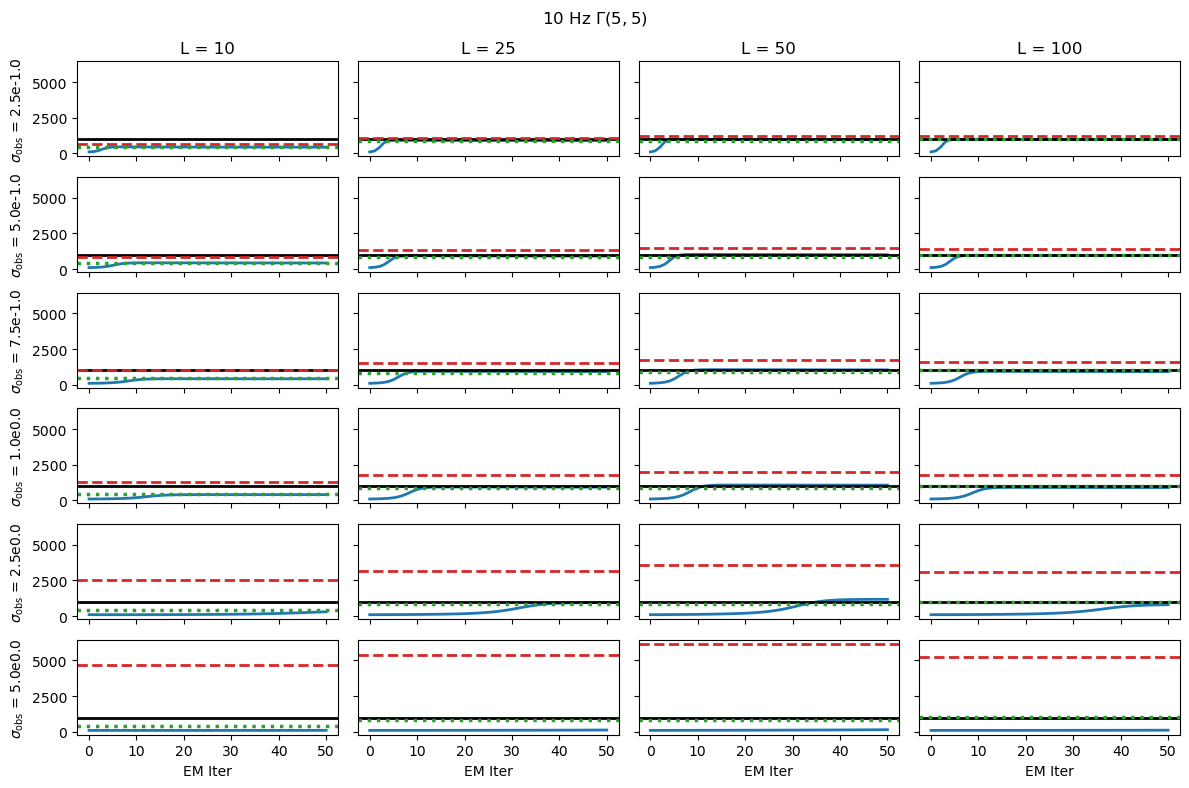

In [40]:

jind = 0
jind_full = 9

K_plot = [5]
# def func(x):
#     return 10*jnp.log10(jnp.real(x))
func = jnp.real

fig, ax = plt.subplots(ov_pairs.shape[0], Ls.size, figsize=(12,8), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, ov_pair in enumerate(ov_pairs):
        ov1 = ov_pair[0]
        ov2 = ov_pair[1]
        res = filter_loaded(res_load, lsel, msel, osel)
        lsel = {'L': L, 'gamma': gamma_name}
        msel = {}
        osel = {'ov1': ov1, 'ov2': ov2}
        
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']

        for k in K_plot:
            plot_cross_spec_func_em_iters(ax[a,l], func, k,k, res['track']['gamma'], res['gamma_init'], 
                j_ind = jind, color=est_color, style=est_style, width=est_width)
            ax[a,l].axhline(func(res['gamma_true_full'][jind_full,k,k]), 
                linestyle=true_style, color=true_color, linewidth=true_width)
            ax[a,l].axhline(func(naive_ests[l,a,jind,k,k]), linestyle=naive_style, color=naive_color, linewidth=naive_width)
            ax[a,l].axhline(func(oracle_ests[l,a,jind,k,k]), linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
        if l == 0:
            ax[a,l].set_ylabel(r'$\sigma_{\text{obs}}$' f' = {ov1}e{ov2}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == ov_pairs.shape[0]-1:
            ax[a,l].set_xlabel('EM Iter')
fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'$\Gamma({K_plot[0]}, {K_plot[0]})$')
plt.tight_layout()

In [41]:
# something is definitely broken here - check batch method... also means L=50 is wrong

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single 

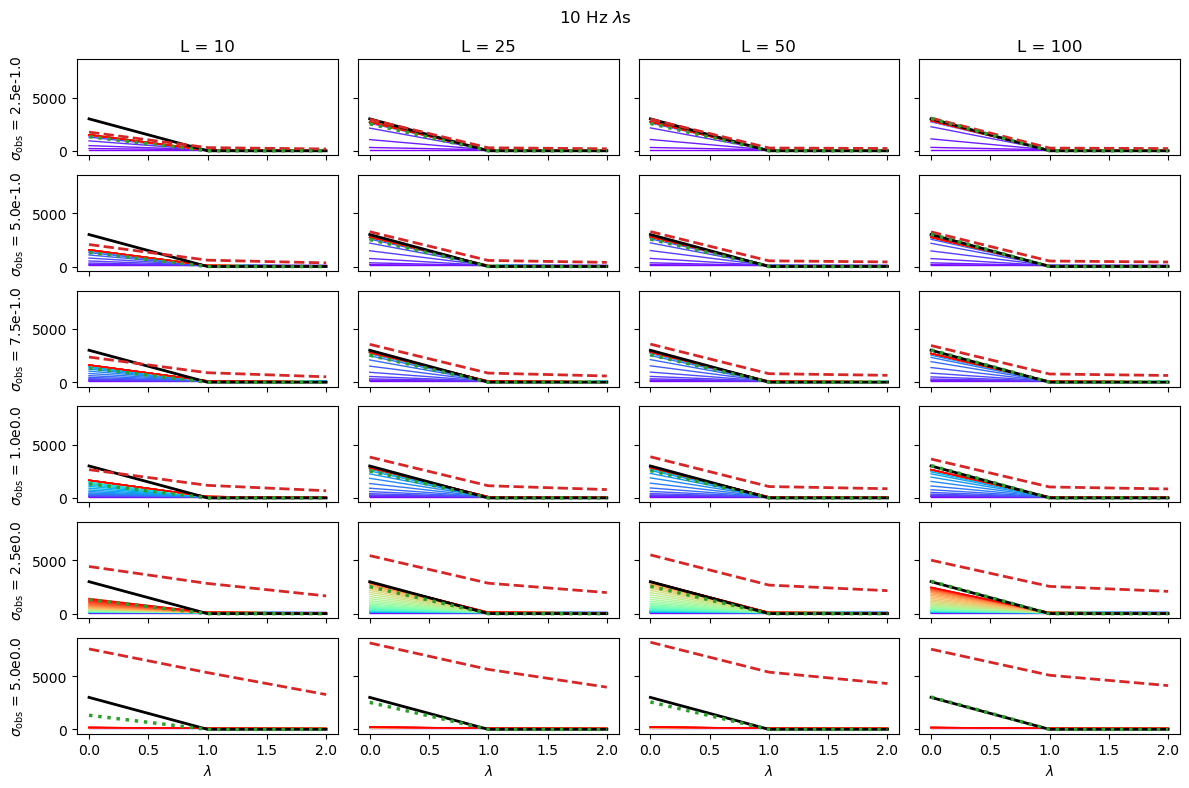

In [43]:
eigrank = 1

fig, ax = plt.subplots(ov_pairs.shape[0], Ls.size, figsize=(12,8), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, ov_pair in enumerate(ov_pairs):
        ov1 = ov_pair[0]
        ov2 = ov_pair[1]
        res = filter_loaded(res_load, lsel, msel, osel)
        lsel = {'L': L, 'gamma': gamma_name}
        msel = {}
        osel = {'ov1': ov1, 'ov2': ov2}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']

        gamma_true = res['gamma_true_full']
        gamma_oracle = oracle_ests[l,a,:,:,:]
        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_est = res['gamma']

        evs_true, _ = jnp.linalg.eigh(gamma_true[jind_full,:,:])
        evs_oracle, _ = jnp.linalg.eigh(gamma_oracle[jind_full,:,:])
        evs_naive, _ = jnp.linalg.eigh(gamma_naive[jind_full,:,:])
        evs_est, _ = jnp.linalg.eigh(gamma_est[jind_full,:,:])

        # plot_eigvals_em_iters(ax[a,l], res['track']['gamma'], res['gamma_init'], j_ind=jind)
        plot_eigvals_em_iters(ax[a,l], res['track']['gamma'], res['gamma_init'], j_ind=jind)
        ax[a,l].plot(evs_true[::-1], linestyle=true_style, color=true_color, linewidth=true_width)
        ax[a,l].plot(evs_naive[::-1],  linestyle=naive_style, color=naive_color, linewidth=naive_width)
        ax[a,l].plot(evs_oracle[::-1],  linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)

        if l == 0:
            ax[a,l].set_ylabel(r'$\sigma_{\text{obs}}$' f' = {ov1}e{ov2}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == ov_pairs.shape[0]-1:
            ax[a,l].set_xlabel(r'$\lambda$')

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'$\lambda$s')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single 

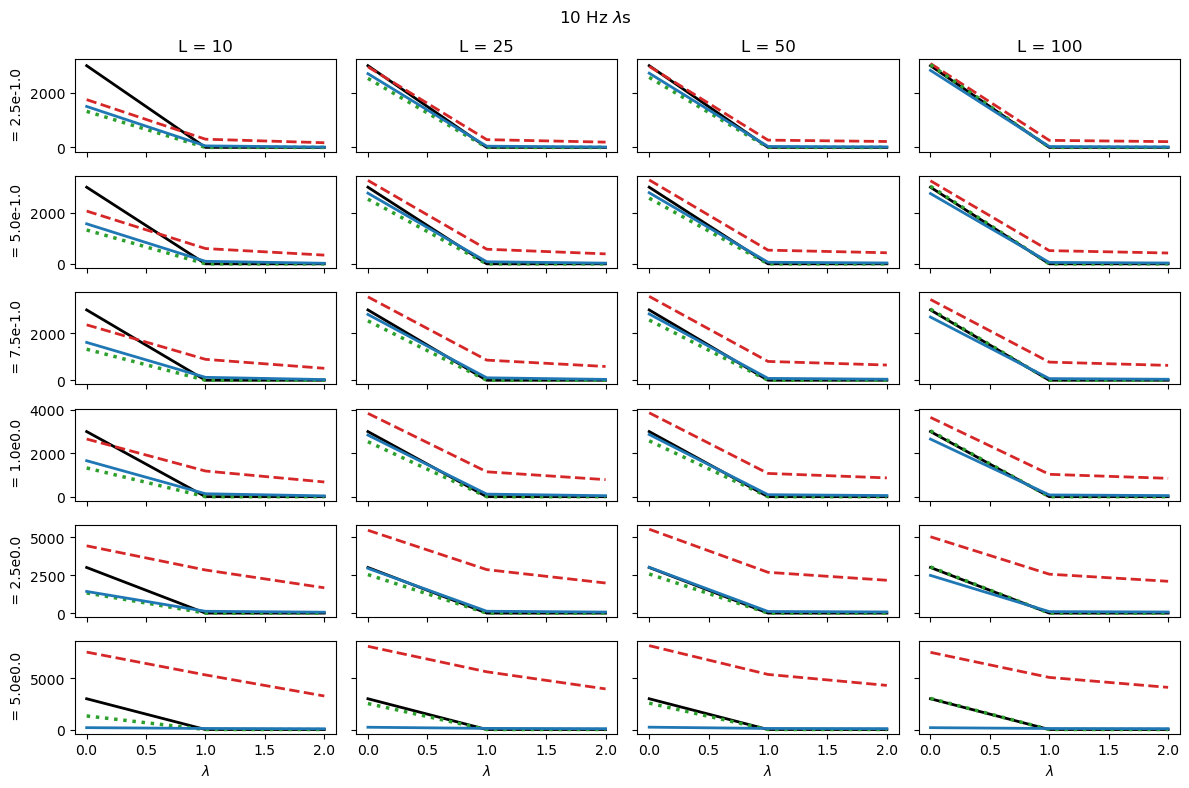

In [50]:
eigrank = 1

fig, ax = plt.subplots(ov_pairs.shape[0], Ls.size, figsize=(12,8), sharex=True, sharey='row')
for l, L in enumerate(Ls):
    for a, ov_pair in enumerate(ov_pairs):
        ov1 = ov_pair[0]
        ov2 = ov_pair[1]
        res = filter_loaded(res_load, lsel, msel, osel)
        lsel = {'L': L, 'gamma': gamma_name}
        msel = {}
        osel = {'ov1': ov1, 'ov2': ov2}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']

        gamma_true = res['gamma_true_full']
        gamma_oracle = oracle_ests[l,a,:,:,:]
        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_est = res['gamma']

        evs_true, _ = jnp.linalg.eigh(gamma_true[jind_full,:,:])
        evs_oracle, _ = jnp.linalg.eigh(gamma_oracle[jind_full,:,:])
        evs_naive, _ = jnp.linalg.eigh(gamma_naive[jind_full,:,:])
        evs_est, _ = jnp.linalg.eigh(gamma_est[jind_full,:,:])

        # plot_eigvals_em_iters(ax[a,l], res['track']['gamma'], res['gamma_init'], j_ind=jind)
        # plot_eigvals_em_iters(ax[a,l], res['track']['gamma'], res['gamma_init'], j_ind=jind)

        ax[a,l].plot(evs_true[::-1], linestyle=true_style, color=true_color, linewidth=true_width)
        ax[a,l].plot(evs_naive[::-1],  linestyle=naive_style, color=naive_color, linewidth=naive_width)
        ax[a,l].plot(evs_oracle[::-1],  linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
        ax[a,l].plot(evs_est[::-1],  linestyle=est_style, color=est_color, linewidth=est_width)


        if l == 0:
            ax[a,l].set_ylabel(f' = {ov1}e{ov2}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == ov_pairs.shape[0]-1:
            ax[a,l].set_xlabel(r'$\lambda$')

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'$\lambda$s')
plt.tight_layout()

# Interest - so need to rotate?

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single 

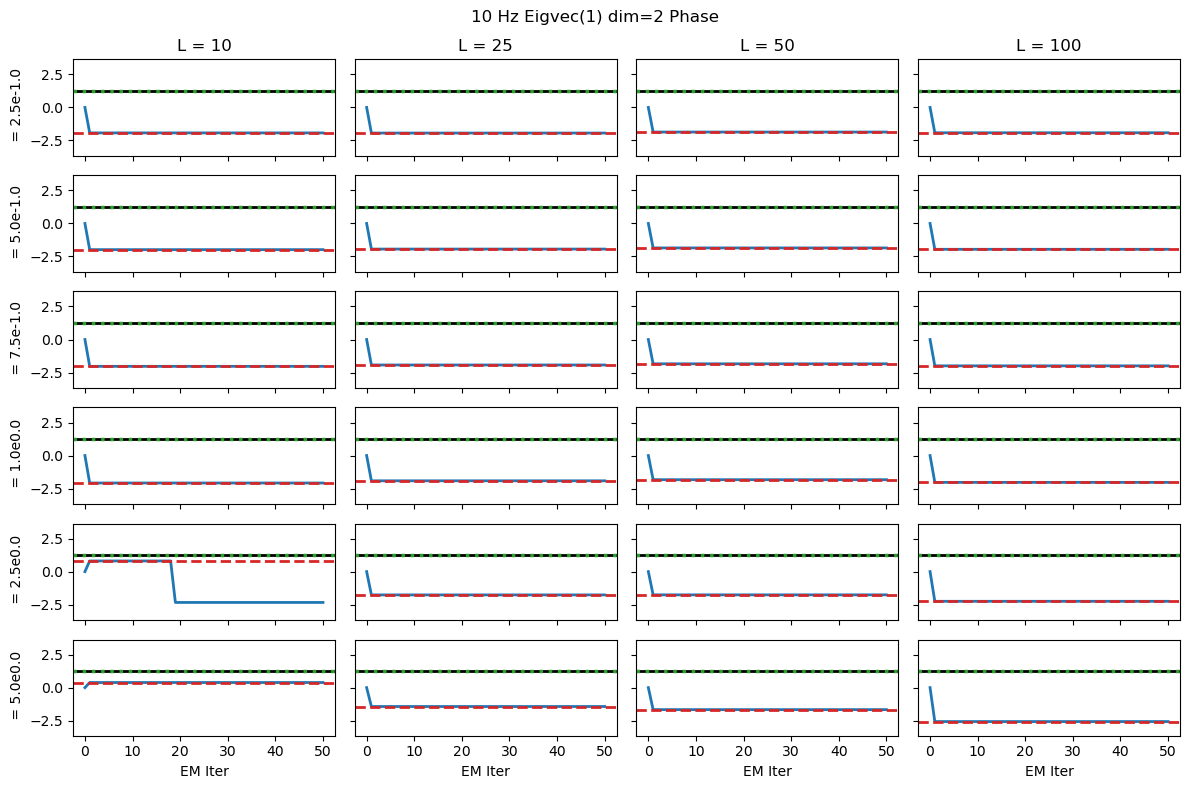

In [45]:
eigrank = 1
func = jnp.angle
z = 0
dims = jnp.array([0,1,2]) + 3*z
# dims = jnp.arange(1)
dims = [1]
fig, ax = plt.subplots(ov_pairs.shape[0], Ls.size, figsize=(12,8), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, ov_pair in enumerate(ov_pairs):
        ov1 = ov_pair[0]
        ov2 = ov_pair[1]
        res = filter_loaded(res_load, lsel, msel, osel)
        lsel = {'L': L, 'gamma': gamma_name}
        msel = {}
        osel = {'ov1': ov1, 'ov2': ov2}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']


        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_oracle = oracle_ests[l,a,:,:,:]

        true_eigvec = get_eigvec(gamma_true[jind_full,:,:], eigrank)
        oracle_eigvec = get_eigvec(gamma_oracle[jind,:,:], eigrank)
        naive_eigvec = get_eigvec(gamma_naive[jind,:,:], eigrank)

        for dim in dims:
            plot_eigvec_func_em_iters(ax[a,l], func, eigrank, dim, res['track']['gamma'], res['gamma_init'], j_ind=9)
            ax[a,l].axhline(func(true_eigvec[dim]), linestyle=true_style, color=true_color, linewidth=true_width)
            ax[a,l].axhline(func(naive_eigvec[dim]), linestyle=naive_style, color=naive_color, linewidth=naive_width)
            ax[a,l].axhline(func(oracle_eigvec[dim]), linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)


        if l == 0:
            ax[a,l].set_ylabel(f' = {ov1}e{ov2}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == ov_pairs.shape[0]-1:
            ax[a,l].set_xlabel('EM Iter')
        ax[a,l].set_ylim([-jnp.pi - 0.5, jnp.pi + 0.5])

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'Eigvec({eigrank}) dim={dim+1} Phase')
plt.tight_layout()

Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single result.
Returned single 

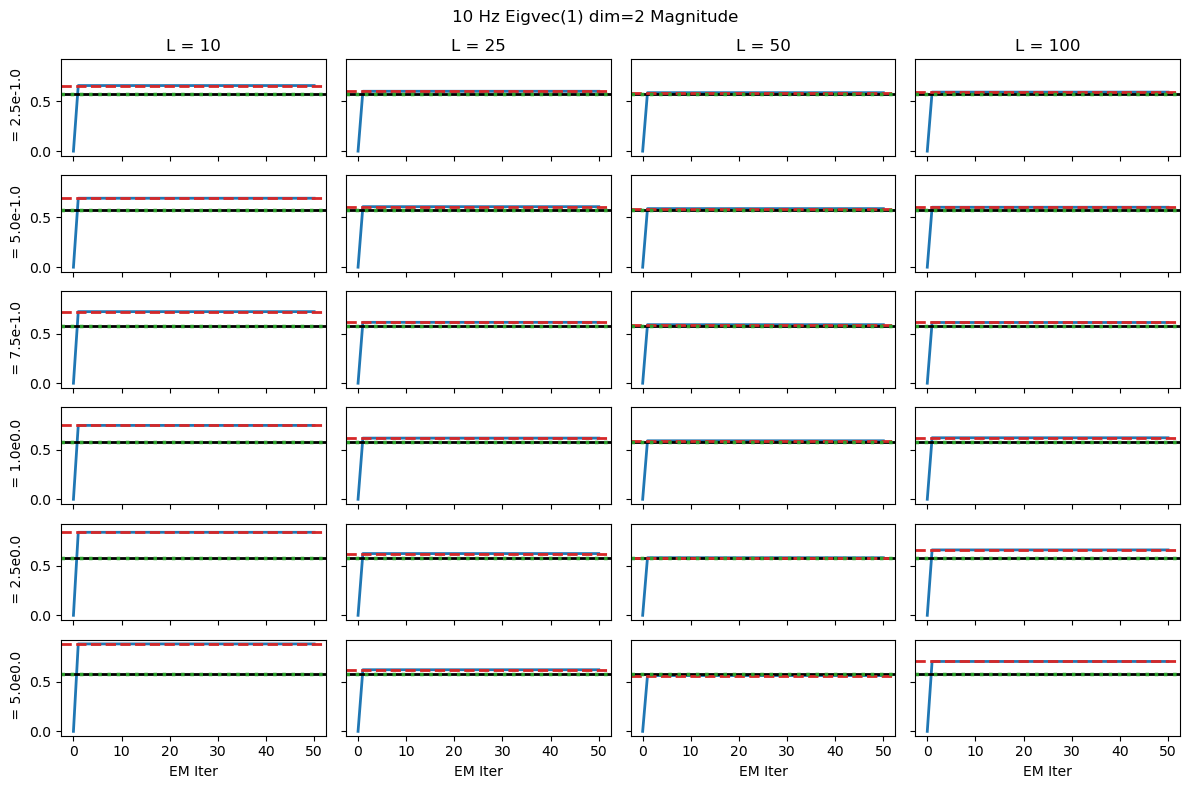

In [46]:
eigrank = 1
func = jnp.abs
z = 0
dims = jnp.array([0,1,2]) + 3*z
# dims = jnp.arange(1)
dims = [1]
fig, ax = plt.subplots(ov_pairs.shape[0], Ls.size, figsize=(12,8), sharex=True, sharey=True)
for l, L in enumerate(Ls):
    for a, ov_pair in enumerate(ov_pairs):
        ov1 = ov_pair[0]
        ov2 = ov_pair[1]
        res = filter_loaded(res_load, lsel, msel, osel)
        lsel = {'L': L, 'gamma': gamma_name}
        msel = {}
        osel = {'ov1': ov1, 'ov2': ov2}
        res = filter_loaded(res_load, lsel, msel, osel)
        cfg = res['cfg']
        gamma_true = res['gamma_true_full']


        gamma_naive = naive_ests[l,a,:,:,:]
        gamma_oracle = oracle_ests[l,a,:,:,:]

        true_eigvec = get_eigvec(gamma_true[jind_full,:,:], eigrank)
        oracle_eigvec = get_eigvec(gamma_oracle[jind,:,:], eigrank)
        naive_eigvec = get_eigvec(gamma_naive[jind,:,:], eigrank)

        for dim in dims:
            plot_eigvec_func_em_iters(ax[a,l], func, eigrank, dim, res['track']['gamma'], res['gamma_init'], j_ind=9)
            ax[a,l].axhline(func(true_eigvec[dim]), linestyle=true_style, color=true_color, linewidth=true_width)
            ax[a,l].axhline(func(naive_eigvec[dim]), linestyle=naive_style, color=naive_color, linewidth=naive_width)
            ax[a,l].axhline(func(oracle_eigvec[dim]), linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)


        if l == 0:
            ax[a,l].set_ylabel(f' = {ov1}e{ov2}')
        if a == 0:
            ax[a,l].set_title(f'L = {L}')
        if a == ov_pairs.shape[0]-1:
            ax[a,l].set_xlabel('EM Iter')

fig.suptitle(f'{nz_model[jind]+1} Hz ' + rf'Eigvec({eigrank}) dim={dim+1} Magnitude')
plt.tight_layout()

In [47]:
eva, eve = jnp.linalg.eigh(gamma_true[9,:,:])
eve[:,-1]

Array([0.5773502 +0.j       , 0.17434967+0.5503959j,
       0.07730769+0.5721512j], dtype=complex64)

In [48]:
eva

Array([-1.4121443e-04,  2.0224947e-04,  3.0000005e+03], dtype=float32)